In [1]:
# PRE-REQUIREMENTS

import os
# Replace the path below with the actual path to your local Git repository
repo_path = r'C:\Users\egeki\OneDrive\Masaüstü\football\Scrape-Whoscored-Event-Data'

# Change directory to the repository
os.chdir(repo_path)

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from matplotlib.patches import ConnectionPatch
from mplsoccer.pitch import Pitch, VerticalPitch
from itertools import combinations
import seaborn as sns
import numpy as np
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import main
import visuals
import seaborn as sns
import requests
import utils

from mplsoccer import VerticalPitch, Pitch
import matplotlib.font_manager as font_manager
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.patches as patches

font_path = 'C:/Users/egeki/Downloads/Arvo/Arvo-Regular.ttf'
font_props = font_manager.FontProperties(fname=font_path)
background_color = '#0C0D0E'

#copy-paste the match URL to be scraped
url = "https://www.whoscored.com/Matches/1842976/Live/Turkey-Super-Lig-2024-2025-Antalyaspor-Galatasaray"

match_score_string = 'Antalyaspor 0-3 Galatasaray' #gotta automatize this at some point...

#logos
# Load a PNG image from a file
home_path = r'C:\Users\egeki\OneDrive\Masaüstü\football\pitchParcelization\antalya.png'
away_path = r'C:\Users\egeki\OneDrive\Masaüstü\football\pitchParcelization\gs.png'

home_logo = Image.open(home_path)
away_logo = Image.open(away_path)

#key plotting design variables for the pass network extraction
max_line_width=200
marker_size=8000
edgewidth=3
dh_arrow_width=20
marker_color='#8B0000'
marker_edge_color='white'
shrink=10
kit_no_size=30
num_color='#FFD700'

%load_ext autoreload
%autoreload 2

In [3]:
if __name__ == "__main__":
    driver = webdriver.Chrome()
    
# whoscored match centre url of the required match (Example: Barcelona vs Sevilla)

match_data = main.getMatchData(driver, url, close_window=True)

# Match dataframe containing info about the match
matches_df = main.createMatchesDF(match_data)

# Events dataframe      
events_df = main.createEventsDF(match_data)

# match Id
matchId = match_data['matchId']

# Information about respective teams as dictionary
home_data = matches_df['home'][matchId]
away_data = matches_df['away'][matchId]

Region: Turkey, League: Super Lig, Season: 2024/2025, Match Id: 1842976


In [5]:
events_df = main.addEpvToDataFrame(events_df)
# Remove duplicate columns
events_df = events_df.loc[:, ~events_df.columns.duplicated()]

In [39]:
# Team data
team = 'Galatasaray'
teamId = 294
opponent = 'Antalyaspor'
venue = 'away'
matchId=match_data['matchId']

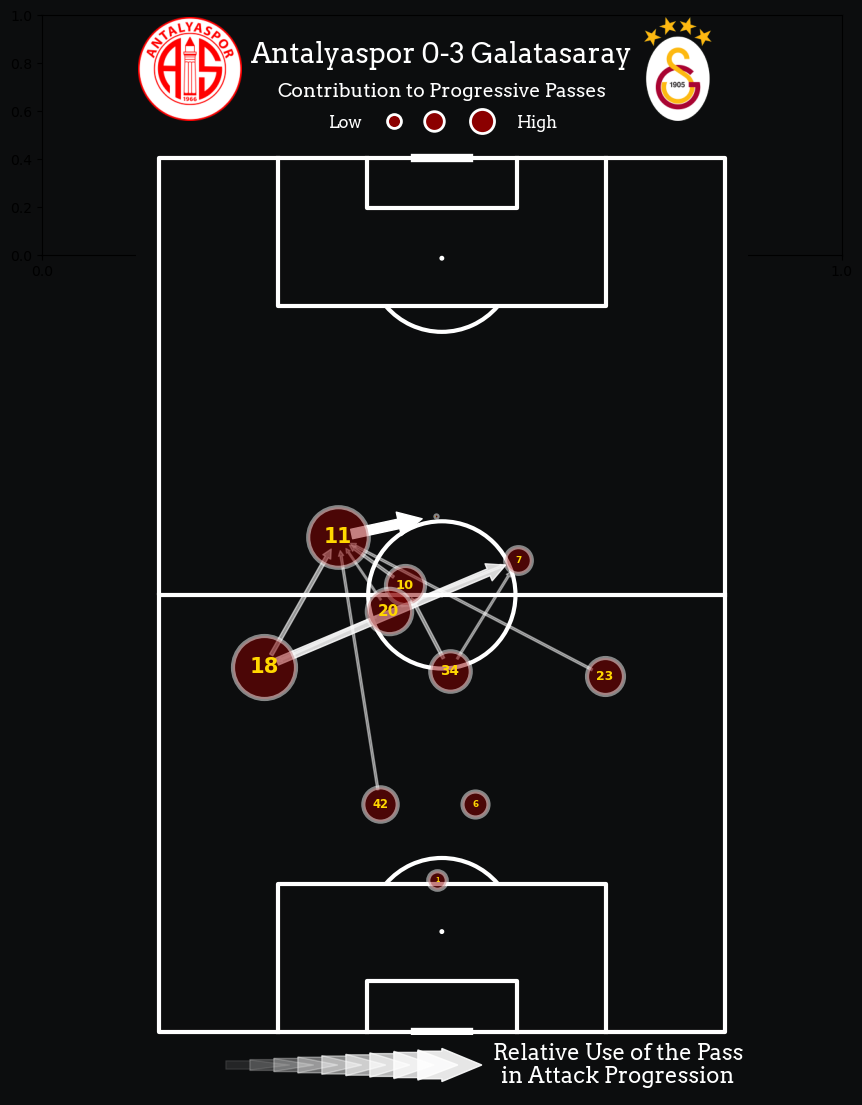

In [49]:
# getting team id and venue
if match_data['home']['name'] == team:
    teamId = match_data['home']['teamId']
    venue = 'home'
else:
    teamId = match_data['away']['teamId']
    venue = 'away'


# getting opponent   
if venue == 'home':
    opponent = match_data['away']['name']
else:
    opponent = match_data['home']['name']


# getting player dictionary
team_players_dict = {}
for player in match_data[venue]['players']:
    team_players_dict[player['playerId']] = player['name']


# getting minute of first substitution
for i in events_df.index:
    if events_df.loc[i, 'type'] == 'SubstitutionOn' and events_df.loc[i, 'teamId'] == teamId:
        sub_minute = str(events_df.loc[i, 'minute'])
        break


# getting players dataframe
match_players_df = pd.DataFrame()
player_names = []
player_ids = []
player_pos = []
player_kit_number = []


for player in match_data[venue]['players']:
    player_names.append(player['name'])
    player_ids.append(player['playerId'])
    player_pos.append(player['position'])
    player_kit_number.append(player['shirtNo'])

match_players_df['playerId'] = player_ids
match_players_df['playerName'] = player_names
match_players_df['playerPos'] = player_pos
match_players_df['playerKitNumber'] = player_kit_number


# extracting passes
# extracting passes
passes_df = events_df.loc[events_df['teamId'] == teamId].reset_index().drop('index', axis=1)
passes_df['playerId'] = passes_df['playerId'].astype('float').astype('Int64')
if 'playerName' in passes_df.columns:
    passes_df = passes_df.drop(columns='playerName')
passes_df.dropna(subset=["playerId"], inplace=True)
passes_df.insert(27, column='playerName', value=[team_players_dict[i] for i in list(passes_df['playerId'])])
if 'passRecipientId' in passes_df.columns:
    passes_df = passes_df.drop(columns='passRecipientId')
    passes_df = passes_df.drop(columns='passRecipientName')
passes_df.insert(28, column='passRecipientId', value=passes_df['playerId'].shift(-1))  
passes_df.insert(29, column='passRecipientName', value=passes_df['playerName'].shift(-1))  
passes_df.dropna(subset=["passRecipientName"], inplace=True)
passes_df = passes_df.loc[passes_df['type'] == 'Pass', :].reset_index(drop=True)
passes_df = passes_df.loc[passes_df['outcomeType'] == 'Successful', :].reset_index(drop=True)
passes_df = passes_df.loc[passes_df['passCorner'] == False, :].reset_index(drop=True)
index_names = passes_df.loc[passes_df['playerName']==passes_df['passRecipientName']].index
passes_df.drop(index_names, inplace=True)
passes_df = passes_df.merge(match_players_df, on=['playerId', 'playerName'], how='left', validate='m:1')
passes_df = passes_df.merge(match_players_df.rename({'playerId': 'passRecipientId', 'playerName':'passRecipientName'},
                                                axis='columns'), on=['passRecipientId', 'passRecipientName'],
                                                how='left', validate='m:1', suffixes=['', 'Receipt'])

#only take the passes that do not involve any sub players (neither on the sending nor on the receiving end)
passes_df = passes_df[passes_df['playerKitNumber'] != 4]
passes_df = passes_df[passes_df['playerKitNumberReceipt'] != 4]
passes_df = passes_df[passes_df['playerKitNumber'] != 53]
passes_df = passes_df[passes_df['playerKitNumberReceipt'] != 53]
passes_df = passes_df[passes_df['playerKitNumber'] != 22]
passes_df = passes_df[passes_df['playerKitNumberReceipt'] != 22]
passes_df = passes_df[passes_df['playerKitNumber'] != 45]
passes_df = passes_df[passes_df['playerKitNumberReceipt'] != 45]
passes_df = passes_df[passes_df['playerKitNumber'] != 44]
passes_df = passes_df[passes_df['playerKitNumberReceipt'] != 44]


# getting team formation
formation = match_data[venue]['formations'][0]['formationName']
formation = '-'.join(formation)
   
# getting player average locations 
location_formation = passes_df[['id','playerKitNumber','x', 'y','playerKitNumberReceipt','endX','endY','EPV']]
location_formation_filt = location_formation[location_formation['EPV'] > 0] #take only the passes with >0 EPV

#average player locations while sending a pass
average_locs_and_count_send = location_formation.groupby('playerKitNumber').agg({'x': ['mean'], 'y': ['mean', 'count']})
average_locs_and_count_send.columns = ['x', 'y', 'count']

#average player locations while receiving a pass
average_locs_and_count_receive = location_formation.groupby('playerKitNumberReceipt').agg({'x': ['mean'], 'y': ['mean', 'count']})
average_locs_and_count_receive.columns = ['x', 'y', 'count']

#you get the average locations of players receiving and sending passes
#this means you will plot their average location in which they were involved in a pass exchange
average_locs_and_count = pd.DataFrame()
average_locs_and_count['x'] = (average_locs_and_count_send['x'] * average_locs_and_count_send['count'] + average_locs_and_count_receive['x'] * average_locs_and_count_receive['count']) / (average_locs_and_count_send['count'] + average_locs_and_count_receive['count'])
average_locs_and_count['y'] = (average_locs_and_count_send['y'] * average_locs_and_count_send['count'] + average_locs_and_count_receive['y'] * average_locs_and_count_receive['count']) / (average_locs_and_count_send['count'] + average_locs_and_count_receive['count'])

# getting separate dataframe for selected columns 
passes_formation = location_formation[['id', 'playerKitNumber', 'playerKitNumberReceipt']].copy()
passes_formation['EPV'] = passes_df['EPV']

#this is just all the passes events but filtered with EPV > 0 (so not grouped by player identity yet)
passes_progressive = passes_df[passes_df['EPV'] > 0]


# getting dataframe for passes between players
passes_between = passes_formation.groupby(['playerKitNumber', 'playerKitNumberReceipt']).agg({ 'id' : 'count', 'EPV' : 'sum'}).reset_index()        
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='playerKitNumberReceipt', right_index=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='playerKitNumber', right_index=True,
                                      suffixes=['', '_end'])


# you will only use this one for getting the total EPV production of each player (based on only progressive passes, so the EPV will always be positive)
# you need this to just plot the size of each player on the field, which will correlate with their EPV production
passes_prog = passes_progressive.groupby(['playerKitNumber', 'playerKitNumberReceipt']).agg({ 'id' : 'count', 'EPV' : 'sum'}).reset_index()        
passes_prog.rename({'id': 'pass_count'}, axis='columns', inplace=True)
passes_prog = passes_prog.merge(average_locs_and_count_send, left_on='playerKitNumberReceipt', right_index=True)
passes_prog = passes_prog.merge(average_locs_and_count_send, left_on='playerKitNumber', right_index=True,
                                  suffixes=['', '_end'])

epv_sums = passes_prog.groupby('playerKitNumber').agg({'EPV': ['sum']}).reset_index()
# Calculate pass_filter by adding one standard deviation to the mean
epv_filter = 0.03 #this value is for EPV filter
passes_between = passes_between.loc[passes_between['EPV'] > epv_filter] #only the pass options that produce above this EPV will be displayed on graph

# filtering passes
# Calculate the mean of 'pass_count'
#mean_passes = passes_between['pass_count'].mean()

# Calculate the standard deviation of 'pass_count'
#std_passes = passes_between['pass_count'].std()

# Calculate pass_filter by adding one standard deviation to the mean
#pass_filter = round(mean_passes + std_passes)
#print("Mean:", mean_passes)
#print("STD:", std_passes)
#print("Mean + 1 Standard Dev.:", pass_filter)
#passes_between = passes_between.loc[passes_between['pass_count'] > pass_filter]


# calculating the line width 
#passes_between['width'] = passes_between.pass_count / passes_between.pass_count.max() * max_line_width
#passes_between = passes_between.reset_index(drop=True)


# setting color to make the lines more transparent when fewer passes are made
min_transparency = 0.3
color = np.array(to_rgba('white'))
color = np.tile(color, (len(passes_between), 1))
c_transparency = passes_between.EPV / passes_between.EPV.max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:, 3] = c_transparency
passes_between['alpha'] = color.tolist()


# separating paired passes from normal passes
passes_between_threshold = 15
filtered_pair_df = []
pair_list = [comb for comb in combinations(passes_between['playerKitNumber'].unique(), 2)]
for pair in pair_list:
    df = passes_between[((passes_between['playerKitNumber']==pair[0]) & (passes_between['playerKitNumberReceipt']==pair[1])) | 
                        ((passes_between['playerKitNumber']==pair[1]) & (passes_between['playerKitNumberReceipt']==pair[0]))]
    if df.shape[0] == 2:
        if (np.array(df.pass_count)[0] >= passes_between_threshold) and (np.array(df.pass_count)[1] >= passes_between_threshold):
            filtered_pair_df.append(df)
            passes_between.drop(df.index, inplace=True)
if len(filtered_pair_df) > 0:
    filtered_pair_df = pd.concat(filtered_pair_df).reset_index(drop=True)
    passes_between = passes_between.reset_index(drop=True)


# plotting
# Create Pass Network - Progressive Passes Sent    
# you can change marker_label to 'name' as well
fig = plt.figure(figsize=(8,12))
fig.patch.set_facecolor(background_color)

ax1 = fig.add_axes([0, 0.7, 1, .2])
ax1.set_facecolor(background_color)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

ax1.text(
    x=0.5, 
    y=.8, 
    s=match_score_string, 
    fontsize=20, 
    fontproperties=font_props, 
    fontweight='bold', 
    color='white', 
    ha='center'
)

ax1.text(
    x=0.5, 
    y=.66, 
    s=f'Contribution to Progressive Passes', 
    fontsize=14,
    fontweight='bold',
    fontproperties=font_props, 
    color='white', 
    ha='center'
)

ax1.text(
    x=0.38, 
    y=0.53, 
    s=f'Low', 
    fontsize=12, 
    fontproperties=font_props, 
    color='white', 
    ha='center'
)

# add a scatter point between the two texts
ax1.scatter(
    x=0.44, 
    y=0.56, 
    s=100, 
    color=marker_color, 
    edgecolor='white', 
    linewidth=2
)
ax1.scatter(
    x=0.49, 
    y=0.56, 
    s=200, 
    color=marker_color, 
    edgecolor='white', 
    linewidth=2
)
ax1.scatter(
    x=0.55,
    y=0.56, 
    s=300, 
    color=marker_color, 
    edgecolor='white', 
    linewidth=2
)

ax1.text(
    x=0.62, 
    y=0.53, 
    s=f'High', 
    fontsize=12, 
    fontproperties=font_props, 
    color='white',
    ha='center'
)


ax2 = fig.add_axes([.05, .05, 0.9, .75])

# plotting
pitch = VerticalPitch(
    pitch_type='opta', 
    pitch_color=background_color,
    pad_bottom=.5, 
    line_color='white',
    linewidth=3,
    axis=False, label=False,
)
pitch.draw(ax=ax2, constrained_layout=True, tight_layout=True)

#placing the z-axis depths differently for each layer of player
average_locs_and_count['zorder'] = list(np.linspace(1,5,11))

counter=0
for i in average_locs_and_count_send.index:
    pitch.scatter(average_locs_and_count.loc[i, 'x'], average_locs_and_count.loc[i, 'y'], s=(marker_size*epv_sums['EPV']['sum'].iloc[counter]),
                  color=marker_color, edgecolors=marker_edge_color, linewidth=edgewidth, 
                  alpha=0.5, zorder=average_locs_and_count.loc[i, 'zorder'], ax=ax2)
    counter=counter+1

for i in passes_between.index:
    x = passes_between.loc[i, 'x']
    y = passes_between.loc[i, 'y']
    endX = passes_between.loc[i, 'x_end']
    endY = passes_between.loc[i, 'y_end']
    coordsA = "data"
    coordsB = "data"
    con = ConnectionPatch([endY, endX], [y, x],
                          coordsA, coordsB,
                          arrowstyle="simple", shrinkA=shrink, shrinkB=shrink,
                          mutation_scale=passes_between.loc[i, 'EPV']*max_line_width, color=passes_between.loc[i, 'alpha'])
    ax2.add_artist(con)

if len(filtered_pair_df) > 0:
    for i in filtered_pair_df.index:
        x = filtered_pair_df.loc[i, 'x']
        y = filtered_pair_df.loc[i, 'y']
        endX = filtered_pair_df.loc[i, 'x_end']
        endY = filtered_pair_df.loc[i, 'y_end']
        coordsA = "data"
        coordsB = "data"
        con = ConnectionPatch([endY, endX], [y, x],
                              coordsA, coordsB,
                              arrowstyle="<|-|>", shrinkA=shrink, shrinkB=shrink,
                              mutation_scale=dh_arrow_width, lw=filtered_pair_df.loc[i, 'width']*max_line_width/5, 
                              color=filtered_pair_df.loc[i, 'alpha'])
        ax2.add_artist(con)
counter=0
for i in average_locs_and_count_send.index:
    if epv_sums['EPV']['sum'].iloc[counter]>0:
        size = kit_no_size*(epv_sums['EPV']['sum'].iloc[counter]**(1/2))
    else:
        size = 10
        
    pitch.annotate(i, xy=(average_locs_and_count.loc[i, 'x'], average_locs_and_count.loc[i, 'y']), 
                   family='DejaVu Sans', c=num_color, 
                   va='center', ha='center', zorder=average_locs_and_count.loc[i, 'zorder'], size=size, weight='bold', ax=ax2)
    #print(kit_no_size*(epv_sums.iloc[counter]**(1/2)))
    counter=counter+1

ax3 = fig.add_axes([0, 0, 1, .05])
ax3.set_facecolor(background_color)

# Define arrow properties
start_x, start_y = 0.2, 0.5  # Starting coordinates (left end of axis)
end_x, end_y = 0.5, 0.5      # Ending coordinates (right end of axis)

# Create multiple segments of the arrow for increasing thickness and decreasing transparency
n_segments = 10  # Number of segments to create the gradient effect
arrow_length = end_x - start_x
arrow_width_min = 0.1  # Smaller width to fit the narrow axis
arrow_width_max = 0.5   # Maximum width for the thickest part
head_width_scale = 1.2   # Adjust head width scaling
head_length = 0.05       # Define a smaller head length

for i in range(n_segments):
    # Calculate the width and transparency for each segment
    width = arrow_width_min + (arrow_width_max - arrow_width_min) * (i / n_segments)
    alpha = (i / n_segments)  # Gradually decreasing transparency

    # Define segment positions (they move along the length of the axis)
    segment_start_x = start_x + (arrow_length * i / n_segments)
    segment_end_x = start_x + (arrow_length * (i + 1) / n_segments)

    # Draw each arrow segment with increasing width and decreasing transparency
    ax3.add_patch(patches.FancyArrow(segment_start_x, start_y, 
                                     segment_end_x - segment_start_x,0,
                                     width=width,
                                     head_width=width * head_width_scale,  # Smaller head width
                                     head_length=head_length,  # Shorter arrow head length
                                     color='white', alpha=alpha))

# Set the limits of the custom axis and hide the axis ticks
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.set_aspect('auto')  # Auto aspect ratio for this narrow axis
ax3.axis('off')  # Turn off axis for better visibility

ax3.text(x=0.72, 
    y=.60, 
    s=f'Relative Use of the Pass', 
    fontsize=16, 
    fontproperties=font_props, 
    color='white', 
    ha='center'
)
ax3.text(x=0.72, 
    y=.2, 
    s=f'in Attack Progression', 
    fontsize=16, 
    fontproperties=font_props, 
    color='white', 
    ha='center'
)


ax4 = fig.add_axes([.12,.79,.13,.13])
ax4.axis('off')
img = home_logo
ax4.imshow(img)

ax5 = fig.add_axes([.73,.79,.13,.13])
ax5.axis('off')
img = away_logo
ax5.imshow(img)

In [55]:
# Save the figure
fig.savefig(r'C:\Users\egeki\OneDrive\Masaüstü\football\pitchParcelization\Antalya_Gs_passNetwork.png', facecolor=background_color, bbox_inches='tight', dpi=600)